In [9]:
# if you are havign difficulty downloading numpy or scipy (requirements for sklearn), 
# https://scikit-learn.org/stable/modules/tree.html
from sklearn import tree, metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [52]:
# load data cleaned from rscript
sc_df = pd.read_csv('../sc_decisions_final.csv')

# drop first col of indexes
sc_df = sc_df.iloc[: , 1:]

sc_df.head()

,c_lcDisagreement,c_lcDispositionDirection,c_issueArea,c_adminActionBool,c_oralArgBool,c_reargBool,c_decisionTime,c_formerCourt,c_caseOriginRegion,c_caseOriginCourt,...,e_decisionPresidentParty,e_JCApproval,j_justiceGender,j_justiceDecisionAgeBand,j_justiceRegion,j_justiceReligion,j_justiceEthnicity,j_justicePresidentParty,j_justiceVotesAppointed,direction
0,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Democrat,Approve,Male,65+,Midwest,Lutheran,Caucasian,Republican,<75%,Liberal
1,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,>=75%,Liberal
2,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Democrat,Approve,Female,65+,West,NaN,Caucasian,Republican,>=75%,Liberal
3,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,0-65,Northeast,Catholicism,Caucasian,Republican,>=75%,Conservative
4,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,0-65,West,Catholicism,Caucasian,Republican,>=75%,Liberal


In [3]:
sc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14047 entries, 0 to 14046
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   c_chief                   14047 non-null  object 
 1   c_lcDisagreement          14029 non-null  float64
 2   c_lcDispositionDirection  14047 non-null  object 
 3   c_issueArea               14047 non-null  object 
 4   c_adminActionBool         14047 non-null  int64  
 5   c_oralArgBool             14047 non-null  int64  
 6   c_reargBool               14047 non-null  int64  
 7   c_decisionTime            14047 non-null  object 
 8   c_formerCourt             14047 non-null  int64  
 9   c_caseOriginRegion        12676 non-null  object 
 10  c_caseOriginCourt         12676 non-null  object 
 11  e_houseMajority           14047 non-null  object 
 12  e_senateMajority          14047 non-null  object 
 13  e_decisionPresidentParty  14047 non-null  object 
 14  e_JCAp

In [53]:
# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

In [54]:
# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

# encode target
y = y.apply(lambda x: x.cat.codes)

# check target encoding
# y.apply(lambda x: x.cat.categories) 

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool], axis = 1)

In [51]:
test = X[['j_justiceReligion_Episcopalian', 'j_justiceReligion_Jewish',
       'j_justiceReligion_Judaism', 'j_justiceReligion_Lutheran',
       'j_justiceReligion_N/A', 'j_justiceReligion_Protestant']]
test[test.sum(axis=1) > 1]

,j_justiceReligion_Episcopalian,j_justiceReligion_Jewish,j_justiceReligion_Judaism,j_justiceReligion_Lutheran,j_justiceReligion_N/A,j_justiceReligion_Protestant


In [55]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 60)
Testing split input-  (3512, 60)


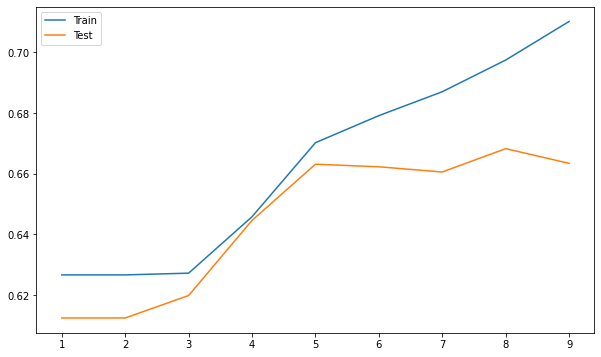

In [56]:
# test for overfitting/underfitting
train_scores = []
test_scores = []

# tree depth
depths = [i for i in range(1, 10)]

# evaluate decision tree for each depth
for i in depths:
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)

# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('max_depth_dt.png')
# depth of around 4

In [57]:
# create tree object
tree = DecisionTreeClassifier(max_depth=5) # test depth

# train tree
model = tree.fit(X_train, y_train)

In [58]:
# predict test target
y_pred = model.predict(X_test)

# accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6631548974943052


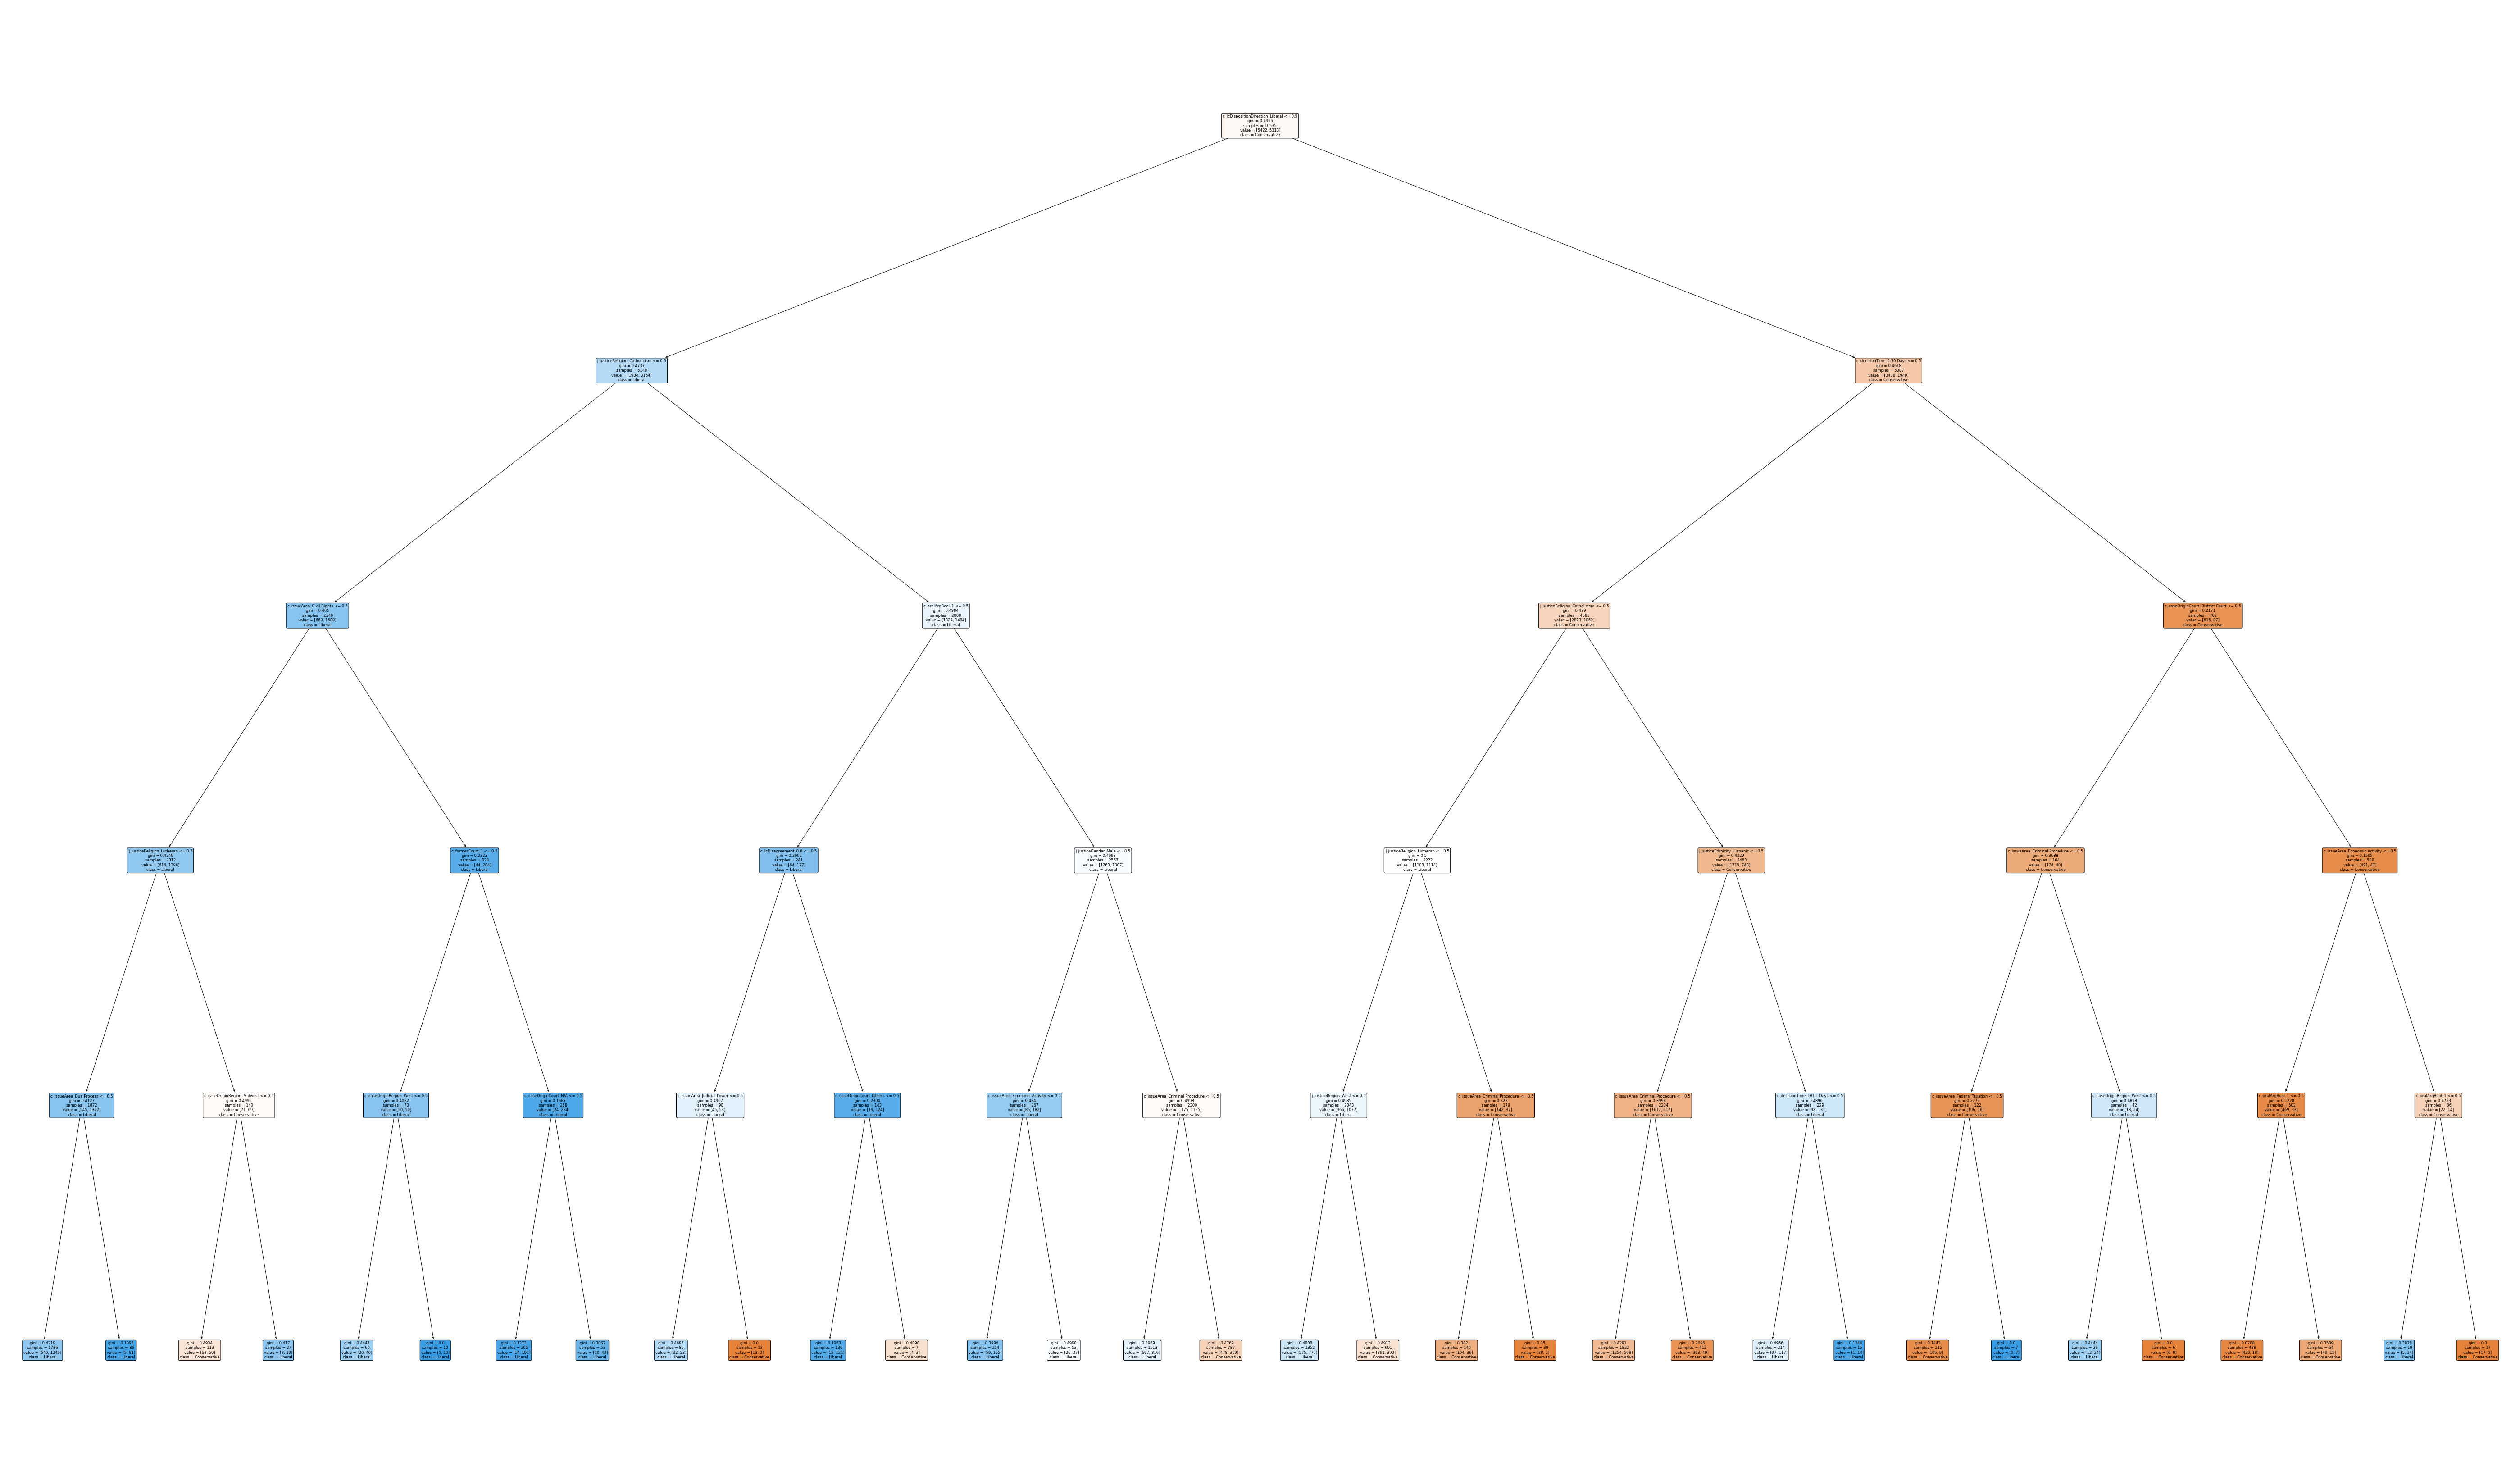

In [59]:
plt.figure(figsize=(100,60)) 
plot_tree(decision_tree=model, feature_names = X.columns, 
                      class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('dt.png')

In [61]:
# Feature importances
importances = model.feature_importances_

pd.DataFrame(data = {
    'feature': X.columns,
    'importance': importances
}).sort_values("importance", ascending = False).head(10)

,feature,importance
4,c_lcDispositionDirection_Liberal,0.363575
38,j_justiceReligion_Catholicism,0.197625
19,c_decisionTime_0-30 Days,0.098693
8,c_issueArea_Criminal Procedure,0.067691
42,j_justiceReligion_Lutheran,0.049659
47,j_justiceEthnicity_Hispanic,0.039291
49,c_oralArgBool_1,0.039198
37,j_justiceRegion_West,0.019521
56,j_justiceGender_Male,0.019160
7,c_issueArea_Civil Rights,0.018033
